In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

# Self-supervised solution for the signal separation

**Approach**

1. A two step process that first pretrains the base model to extract features and learn similarity. It learns to extract features that are critical for distinguishing between the signal components (i.e what makes the signal of interest different from the interference). *Formulate the problem as a similarity function optimization where the network is trained to minimize the distance (in feature space) between similar signals (eg. clean signals of interest) and maximize the distance between dissimilar signals (eg. interference vs signal of interest)*.
2. Then, it fine-tunes the base model to leverage the learned representations to filter out the signal of interest from a mixture.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from math import sqrt, pi, cos

from rfcutils import generate_qpsk_signal
import os
import h5py
import numpy as np
import tensorflow as tf

2024-04-04 06:04:42.868534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 06:04:42.868614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 06:04:42.869603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 06:04:42.876175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 06:04:45.204750: I tensorflow/core/common_

In [ ]:
"""
Data preparation and loading

Generate QPSK signals
Read the interference signals and curate samples of it
"""

sig_len = 40_960
soi_type = "QPSK"
num_symbols = 16
num_examples_per_class = 1000
interference_signal_set = ["CommSignal2", "CommSignal3", "CommSignal5G1", "EMISignal1"]

os.makedirs("npydataset", exist_ok=True)
os.makedirs(f"npydataset/Dataset_{soi_type}_MoCo_training", exist_ok=True)

# Generate QPSK signals
qpsk_sig, _ , msg_bits, _ = generate_qpsk_signal(num_examples_per_class, sig_len // num_symbols)
intrf_frames = list()
for interference_sig_type in interference_signal_set:
    with h5py.File(os.path.join("dataset/interferenceset_frame", interference_sig_type + "_raw_data.h5"), "r") as f:
        intrf_frames.append(np.array(f.get("dataset")))

for i, intrf_frame in enumerate(intrf_frames):
    idxs = np.random.randint(intrf_frame.shape[1] - sig_len, size=intrf_frame.shape[0])
    idxs = tf.cast(idxs.reshape(-1, 1) + np.arange(sig_len).reshape(1, -1), tf.int32)
    intrf_frames[i] = tf.experimental.numpy.take_along_axis(intrf_frame, idxs, axis=1)

# save all signals
for i in range(num_examples_per_class):
    np.save(f"npydataset/Dataset_{soi_type}_MoCo_training/QPSK_{i + 1}.npy", qpsk_sig[i])
    for j, intrf_frame in enumerate(intrf_frames):
        if i >= intrf_frame.shape[0]:
            continue
        np.save(f"npydataset/Dataset_{soi_type}_MoCo_training/{interference_signal_set[j]}_{i + 1}.npy", intrf_frame[i])


In [3]:
"""
Define the base model for self-supervised learning using contrastive loss function as WaveNet.

The model is trained using contrastive loss function to learn the representations of a signal of interest (QPSK or QPSKOFDM).
The model is trained using the contrastive loss function to learn the representations of the signal of interest against augemented
signals (time-shifted, amplitude scaled, noise-added and inteference-added signals).

The model is based on the WaveNet architecture with residual blocks and dilated convolutions.
Orignally, the WaveNet model is used for speech synthesis, but it can be used for any signal processing tasks.
We modify the WaveNet model to be used for self-supervised learning tasks by replacing the output projection layer with a siamese network.
"""
class ResidualBlock(nn.Module):
    def __init__(self, residual_channels, dilation):
        super(ResidualBlock, self).__init__()
        self.dilated_conv = nn.Conv1d(
            residual_channels, 2*residual_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.output_projection = nn.Conv1d(
            residual_channels, 2 * residual_channels, kernel_size=1)

    def forward(self, x):
        y = self.dilated_conv(x) # ouput shape: (batch_size, 2*residual_channels, seq_len)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter) # ouput shape: (batch_size, residual_channels, seq_len)

        residual, skip = torch.chunk(self.output_projection(y), 2, dim=1)

        return (x + residual) / sqrt(2.0), skip


class Wave(nn.Module):
    def __init__(self, input_channels, residual_channels, residual_layers, dilation_cycle_length):
        super(Wave, self).__init__()
        self.input_projection = nn.Conv1d(input_channels, residual_channels, kernel_size=1)
        
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(residual_channels, 2**(i % dilation_cycle_length)) for i in range(residual_layers)
        ])
        self.skip_projection = nn.Conv1d(residual_channels, residual_channels, kernel_size=1)
        self.output_projection = nn.Conv1d(residual_channels, input_channels, kernel_size=1) # should be replaced with siamese network

    def forward(self, x):
        x = self.input_projection(x)
        x = F.relu(x)
        
        skip = None
        for layer in self.residual_blocks:
            x, skip_connection = layer(x) # TODO: find out why the residual outputs of the residual blocks are not used
            skip = skip_connection if skip is None else skip + skip_connection


        x = skip / sqrt(len(self.residual_blocks)) # normalize skip connections by 1 / sqrt(num_residual_blocks)
        x = self.skip_projection(x)
        x = F.relu(x)
        x = self.output_projection(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"Using device: " + str(device)

'Using device: cuda'

In [5]:
model = Wave(2, 128, 30, 10).to(device)
"There are {:.2f} million parameters in the model".format(sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6)

'There are 3.96 million parameters in the model'

In [ ]:
y = model(torch.rand(1, 2, 40960).to(device))

y.shape


In [12]:
class SiameseWave(nn.Module):
    def __init__(self, input_shape, residual_channels, residual_layers, dilation_cycle_length, T=0.1, device="cuda"):
        super(SiameseWave, self).__init__()
        self.T = T
        self.device = device
        self.base_encoder = Wave(input_shape[0], residual_channels, residual_layers, dilation_cycle_length)
        self.momentum_encoder = Wave(input_shape[0], residual_channels, residual_layers, dilation_cycle_length)

        self.base_encoder.output_projection = nn.Identity()
        self.momentum_encoder.output_projection = nn.Identity()

        # projection heads
        self.base_encoder_projector = self._build_projector_and_predictor_head(3, residual_channels * input_shape[1], 512, 128)
        self.momentum_encoder_projector = self._build_projector_and_predictor_head(3, residual_channels * input_shape[1], 512, 128)

        # predictor head
        self.predictor = self._build_projector_and_predictor_head(2, 128, 512, 128)

        for param_b, param_m in zip(self.base_encoder.parameters(), self.momentum_encoder.parameters()):
            param_m.data.copy_(param_b.data) # update momentum encoder with base encoder's parameters
            param_m.requires_grad = False # disable gradient computation for momentum encoder

        for param_b, param_m in zip(self.base_encoder_projector.parameters(), self.momentum_encoder_projector.parameters()):
            param_m.data.copy_(param_b.data) # update momentum encoder's projector with base encoder's projector
            param_m.requires_grad = False # disable gradient computation for momentum encoder's projector


    def _build_projector_and_predictor_head(self, num_layers, input_dim, mlp_dim, output_dim):
        mlp = []
        for l in range(num_layers):
            dim1 = input_dim if l == 0 else mlp_dim
            dim2 = output_dim if l == num_layers - 1 else mlp_dim

            mlp.append(nn.Linear(dim1, dim2))

            if l < num_layers - 1:
                mlp.extend([nn.BatchNorm1d(dim2), nn.ReLU(inplace=True)])
            else: # remove gamma in BN for simplicity (from SimCLR implementation)
                mlp.append(nn.BatchNorm1d(dim2, affine=False))
        
        return nn.Sequential(*mlp)
    

    def contrastive_loss(self, q, k):
        q = F.normalize(q, dim=1)
        k = F.normalize(k, dim=1)

        k = concat_all_gather(k) # gather all the momentum encoder's outputs from all GPUs

        logits = torch.einsum('nc,mc->nm', q, k) / self.T
        N = logits.shape[0]
        labels = (torch.arange(N, dtype=torch.long) + N * torch.distributed.get_rank()).to(self.device)
        return nn.CrossEntropyLoss()(logits, labels) * (2 * self.T) # multiply by 2 * T to match the SimCLR implementation

    @torch.no_grad()
    def _momentum_encoder_update(self, m):
        for param_b, param_m in zip(self.base_encoder.parameters(), self.momentum_encoder.parameters()):
            param_m.data = param_m.data * m + param_b.data * (1.0 - m)

    def forward(self, x1, x2, m): # x1: signal of interest, x2: augmented signal, m: momentum
        x1 = self.base_encoder(x1)
        x2 = self.base_encoder(x2)

        # flatten the outputs
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        print(x1.shape, x2.shape)

        q1 = self.predictor(self.base_encoder_projector(x1))
        q2 = self.predictor(self.base_encoder_projector(x2))

        with torch.no_grad():
            self._momentum_encoder_update(m) # update the momentum encoder

            x1 = self.momentum_encoder(x1)
            x2 = self.momentum_encoder(x2)

            # flatten the outputs
            x1 = x1.view(x1.size(0), -1)
            x2 = x2.view(x2.size(0), -1)

            k1 = self.momentum_encoder_projector(x1)
            k2 = self.momentum_encoder_projector(x2)

        return self.contrastive_loss(q1, k2) + self.contrastive_loss(q2, k1)
    
@torch.no_grad()
def concat_all_gather(tensor):
    tensors_gather = [torch.ones_like(tensor) for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

In [13]:
class TwoCropsTransform:
    def __init__(self, base_transform1, base_transform2):
        self.base_transform1 = base_transform1
        self.base_transform2 = base_transform2

    def __call__(self, x):
        return self.base_transform1(x), self.base_transform2(x)
    
"""
Implement the following transformation for data augmentation: 
DC shift, 
time shift, 
amplitude scaling, 
zero masking,
additive white Gaussian noise.
"""

class DCShift:
    def __init__(self, shift):
        self.shift = shift
    
    def __call__(self, x):
        return x + self.shift
    
class TimeShift:
    def __init__(self, shift):
        self.shift = shift
    
    def __call__(self, x):
        return torch.roll(x, self.shift, dims=-1)
    
class AmplitudeScaling:
    def __init__(self, scale):
        self.scale = scale
    
    def __call__(self, x):
        return x * self.scale
    
class ZeroMasking:
    def __init__(self, mask_ratio):
        self.mask_ratio = mask_ratio
    
    def __call__(self, x):
        mask = torch.ones_like(x)
        rng = int(self.mask_ratio * x.size(-1))
        start_idx = torch.randint(0, x.size(-1) - rng, (1,)).item()
        mask[..., start_idx:start_idx + rng] = 0
        return x * mask

class AdditiveWhiteGaussianNoise:
    def __init__(self, std):
        self.std = std
    
    def __call__(self, x):
        return x + torch.randn_like(x) * self.std

In [15]:
"""
Loaders and training loop
"""
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RFSignals(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = os.listdir(root_dir)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        file = self.files[idx]
        sample = np.load(os.path.join(self.root_dir, file), allow_pickle=True)
        sample = np.stack([sample.real, sample.imag], axis=-2).astype(np.float32)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
augmentation1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([DCShift(0.1)]),
    transforms.RandomApply([TimeShift(100)]),
    transforms.RandomApply([AmplitudeScaling(0.5)]),
    transforms.RandomApply([ZeroMasking(0.1)]),
    transforms.RandomApply([AdditiveWhiteGaussianNoise(0.1)])
])

augmentation2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([DCShift(0.1)]),
    transforms.RandomApply([TimeShift(100)]),
    transforms.RandomApply([AmplitudeScaling(0.5)]),
    transforms.RandomApply([ZeroMasking(0.1)]),
    transforms.RandomApply([AdditiveWhiteGaussianNoise(0.1)])
])

dataset = RFSignals(root_dir="npydataset/Dataset_QPSK_MoCo_training",
                     transform=TwoCropsTransform(augmentation1, augmentation2))


torch.Size([8, 2, 40960]) torch.Size([8, 2, 40960])


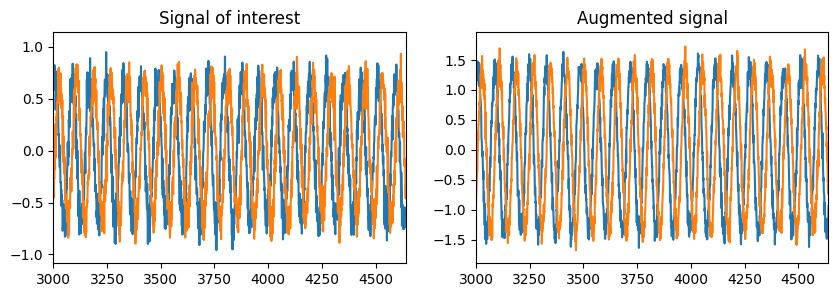

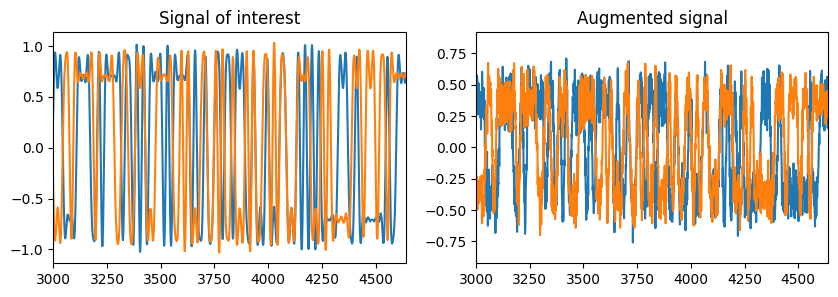

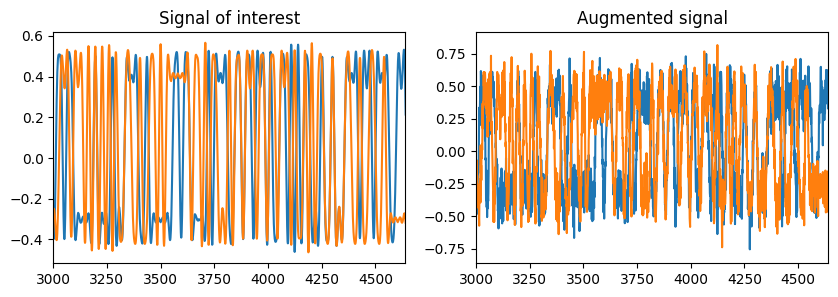

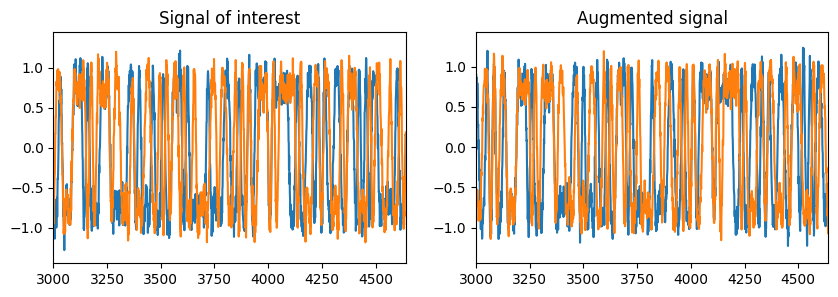

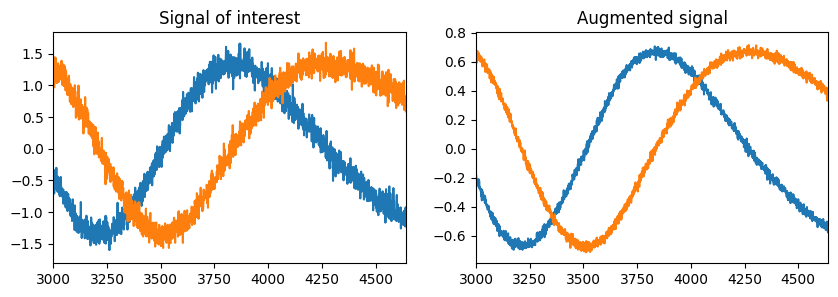

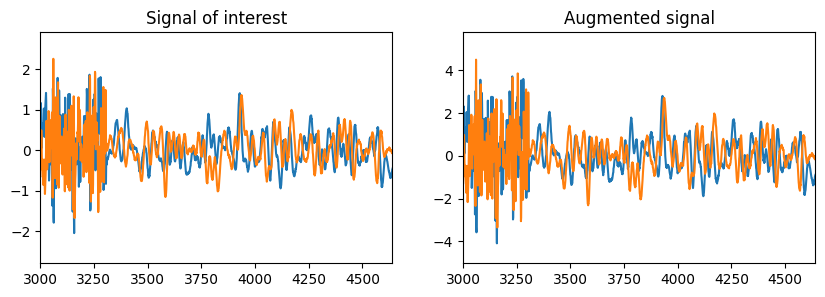

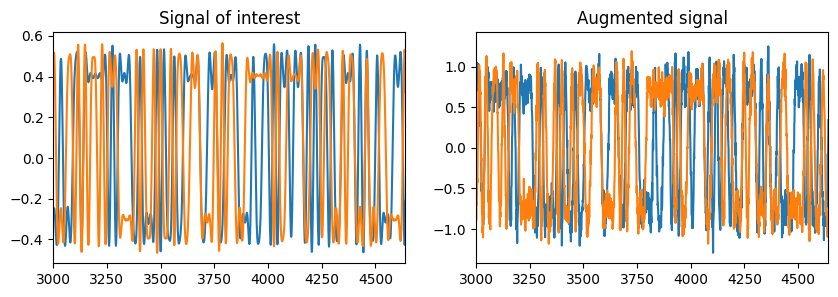

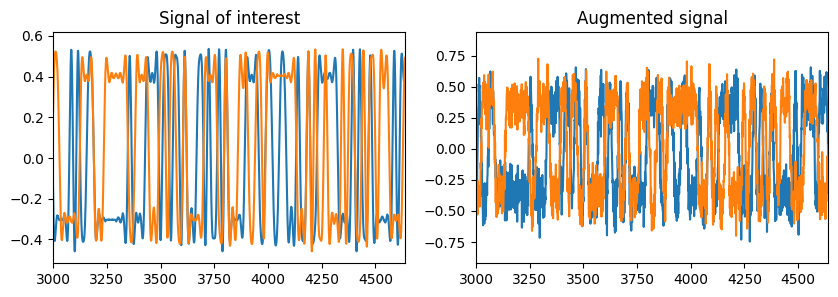

In [16]:
# let's visualize the augmented signals
import matplotlib.pyplot as plt


loader = DataLoader(dataset, batch_size=8, shuffle=True)

for i, (x1, x2) in enumerate(loader):
    if i == 1:
        break
    x1 = x1.squeeze(1)
    x2 = x2.squeeze(1)
    print(x1.shape, x2.shape)
    for j in range(8):
        plt.subplots(1, 2, figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(x1[j].numpy().T)
        plt.title("Signal of interest")
        plt.xlim([3000, 4640])
        plt.subplot(1, 2, 2)
        plt.plot(x2[j].numpy().T)
        plt.title("Augmented signal")
        plt.xlim([3000, 4640])


In [17]:
loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [18]:
model_params = {
    "input_shape": (2, 40960),
    "residual_channels": 128,
    "residual_layers": 2,
    "dilation_cycle_length": 10,
    "T": 0.1,
    "device": device
}

model = SiameseWave(**model_params).to(device)
"There are {:.2f} million parameters in the model".format(sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6)

'There are 2685.10 million parameters in the model'

In [19]:
def adjust_learning_rate(optimizer, epoch, epochs, warmup_epochs, lr):
    """"
    Decays the learning rate with half-cosine after warmup
    """
    if epoch < warmup_epochs:
        lr = lr * epoch / warmup_epochs
    else:
        lr = lr * 0.5 * (1 + cos(pi * (epoch - warmup_epochs) / epochs - warmup_epochs))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def adjust_moco_momentum(epoch, epochs, moco_m):
    """
    Adjust the momentum for MoCo based on current epoch
    """
    m = 1. - 0.5 * (1.  + cos(pi * epoch / epochs)) * (1 - moco_m)
    return m

In [ ]:
EPOCHS = 10
LR = 1e-4
WEIGHT_DECAY = 1e-6
MOCO_M = 0.999
WARMUP_EPOCHS = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    model.train()
    iters_per_epoch = len(loader)
    moco_m = MOCO_M
    for i, (x1, x2) in enumerate(loader):
        lr = adjust_learning_rate(optimizer, epoch, EPOCHS, WARMUP_EPOCHS, LR)
        m = adjust_moco_momentum(epoch * iters_per_epoch + i, EPOCHS * iters_per_epoch, moco_m)

        x1 = x1.squeeze(1).to(device)
        x2 = x2.squeeze(1).to(device)
        with torch.cuda.amp.autocast(True):
            loss = model(x1, x2, m)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        if i % 1000 == 0:
            print(f"Epoch: {epoch + 1}/{EPOCHS}, Iteration: {i + 1}/{iters_per_epoch}, Loss: {loss.item():.4f}, LR: {lr:.4f}, MoCo Momentum: {m:.4f}")